In [ ]:
import cv2
import iris
import matplotlib.pyplot as plt
import numpy as np

from iris.orchestration.environment import Environment
from iris.orchestration.error_managers import store_error_manager
from iris.callbacks.pipeline_trace import NodeResultsWriter, PipelineCallTraceStorage, PipelineCallTraceStorageError
from iris.orchestration.output_builders import build_orb_output, build_simple_debugging_output, build_simple_orb_output

/research/iprobe-farmanif/anaconda3/envs/openiris/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import iris

print(iris.__version__)

/research/iprobe-farmanif/anaconda3/envs/openiris/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.1.0


In [3]:
iris_pipeline = iris.IRISPipeline(env = Environment(
            pipeline_output_builder=build_simple_debugging_output,
            error_manager=store_error_manager,
            call_trace_initialiser=PipelineCallTraceStorage.initialise,
        ))

NameError: name 'Environment' is not defined

In [1]:
img_pixels = cv2.imread("data/images/S1001L01.jpg", cv2.IMREAD_GRAYSCALE)
output = iris_pipeline(img_data=img_pixels, eye_side="left")

NameError: name 'cv2' is not defined

In [5]:
output.keys()

dict_keys(['iris_template', 'metadata', 'segmentation_map', 'segmentation_binarization', 'extrapolated_polygons', 'normalized_iris', 'iris_response', 'error'])

## print out meta data (quality measures)

In [7]:
output['metadata']

{'iris_version': '1.1.0',
 'image_size': (320, 240),
 'eye_side': 'left',
 'eye_centers': {'iris_center': (128.91980433728588, 143.05876295517476),
  'pupil_center': (130.64074515711764, 143.61738212845648)},
 'pupil_to_iris_property': {'pupil_to_iris_diameter_ratio': 0.43788762753970006,
  'pupil_to_iris_center_dist_ratio': 0.017525151795766098},
 'offgaze_score': 0.00034231188836214376,
 'eye_orientation': -0.03552927844925269,
 'occlusion90': 0.9666441542848566,
 'occlusion30': 1.0,
 'iris_bbox': {'x_min': 27.876497268676758,
  'y_min': 40.613128662109375,
  'x_max': 230.10284423828125,
  'y_max': 245.6842803955078}}

# visualize segmentation results

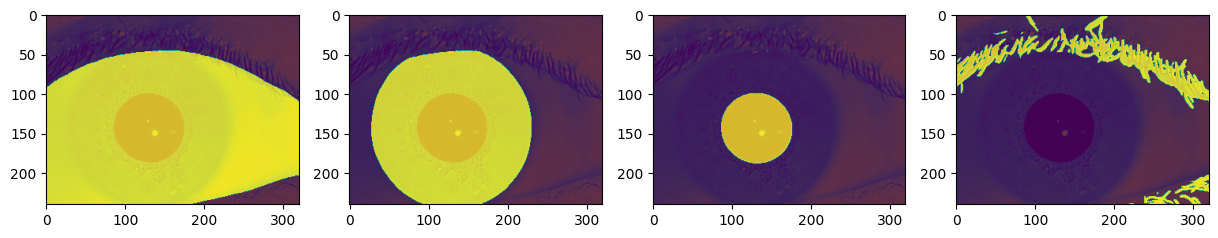

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15, 20))
for i in range(4):
    ax[i].imshow(img_pixels)
    ax[i].imshow(output['segmentation_map']['predictions'][:,:,i], alpha=0.8)

# visualize normalization results

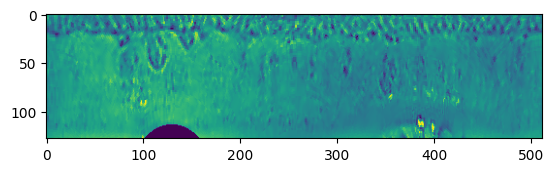

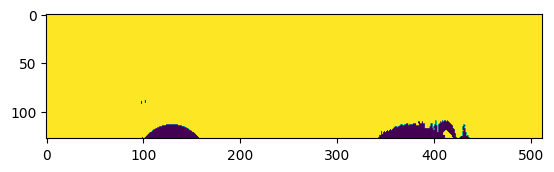

In [9]:
plt.imshow(output['normalized_iris']['normalized_image'])
plt.show()
plt.imshow(output['normalized_iris']['normalized_mask'])

## visualize iris response results

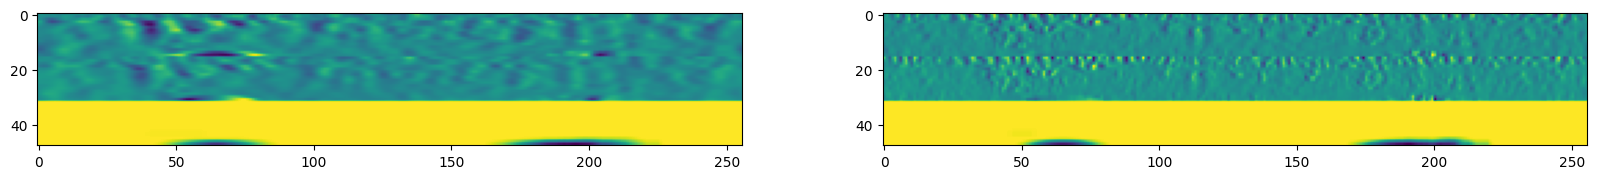

In [10]:
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

fig, ax = plt.subplots(1, 2, figsize=(20, 40))
for i in range(2):
    ax[i].imshow(np.vstack((normalize_array(output['iris_response']['iris_responses'][i].real), normalize_array(output['iris_response']['iris_responses'][i].imag), normalize_array(output['iris_response']['mask_responses'][i]))))

## visualize iris codes results

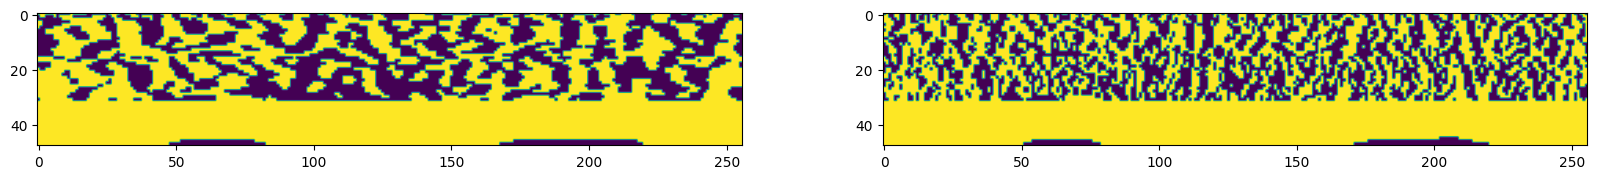

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 40))
for i in range(2):
    ax[i].imshow(np.vstack((output['iris_template'].iris_codes[i][:,:,0], output['iris_template'].iris_codes[i][:,:,1], output['iris_template'].mask_codes[i][:,:,0])))


## visualize gabor filters

In [13]:
from iris.nodes.iris_response.image_filters.gabor_filters import GaborFilter
filters = [
            GaborFilter(
                kernel_size=(41, 21),
                sigma_phi=7,
                sigma_rho=6.13,
                theta_degrees=90.0,
                lambda_phi=28,
                dc_correction=True,
                to_fixpoints=True,
            ),
            GaborFilter(
                kernel_size=(17, 21),
                sigma_phi=2,
                sigma_rho=5.86,
                theta_degrees=90.0,
                lambda_phi=8,
                dc_correction=True,
                to_fixpoints=True,
            ),
]

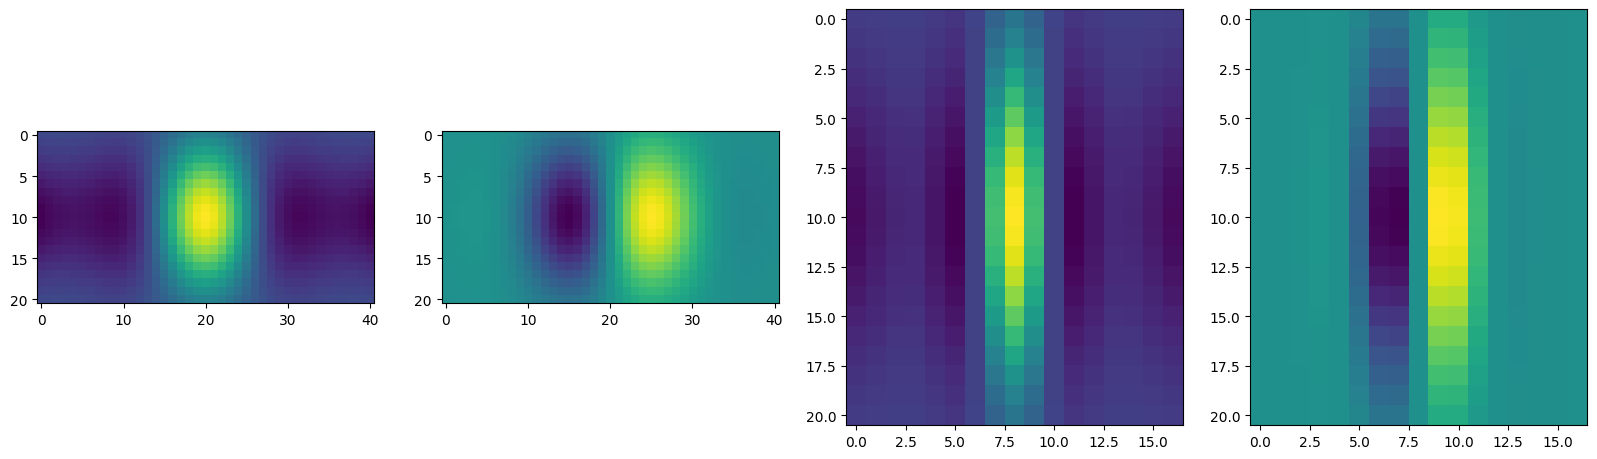

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 60))
for i in range(2):
    kernel_values = filters[i].compute_kernel_values()
    ax[i*2].imshow(kernel_values.real)
    ax[i*2 + 1].imshow(kernel_values.imag)

## use iris.visualization

In [15]:
iris_visualizer = iris.visualisation.IRISVisualizer()

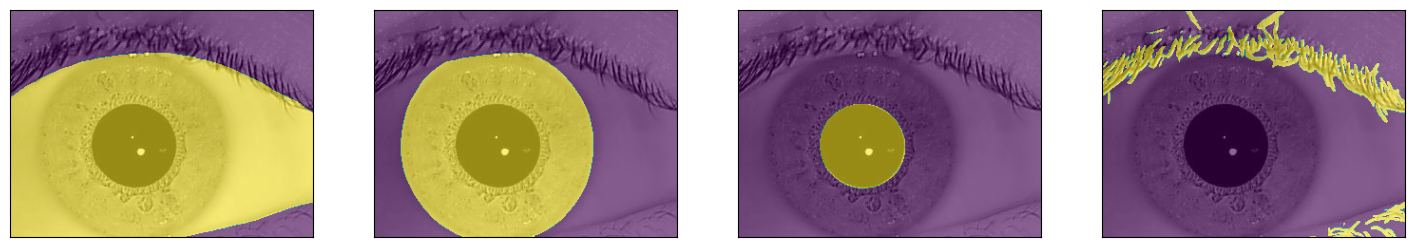

In [16]:
canvas = iris_visualizer.plot_segmentation_map(
    ir_image=iris.IRImage(img_data=img_pixels, eye_side="right"),
    segmap=iris_pipeline.call_trace['segmentation'],
)
plt.show()

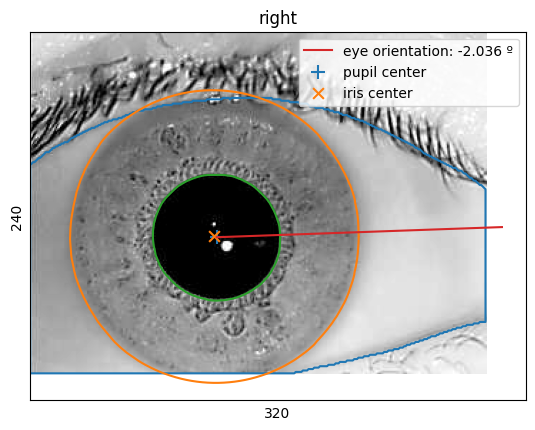

In [17]:
canvas = iris_visualizer.plot_all_geometry(
    ir_image=iris.IRImage(img_data=img_pixels, eye_side="right"),
    geometry_polygons=iris_pipeline.call_trace['geometry_estimation'],
    eye_orientation=iris_pipeline.call_trace['eye_orientation'],
    eye_center=iris_pipeline.call_trace['eye_center_estimation'],
)
plt.show()

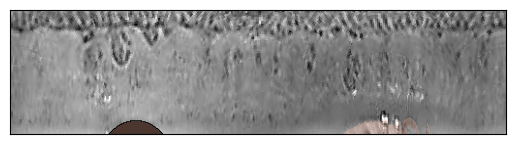

In [18]:
canvas = iris_visualizer.plot_normalized_iris(
    normalized_iris=iris_pipeline.call_trace['normalization'],
)
plt.show()

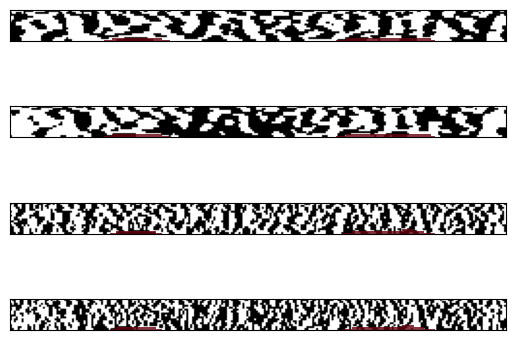

In [19]:
canvas = iris_visualizer.plot_iris_template(
    iris_template=iris_pipeline.call_trace['encoder'],
)
plt.show()